# Random Forest Classifier 

Random Forest Classifier Steps: <br>
- Load Main Dataset <br>
- Split in Dataset for training and testing <br>
- Build Bootstrapped Dataset <br>
- Train Decision Trees on those datasets using diferent groups of features<br>
- Get Test Data and for each entry on the table make it go through all the trees and take note of the results<br>
- Agregate all the results from the different trees and choose the best value thorugh majority voting<br>
            


## Library imports

In [72]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from matplotlib import pyplot 

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


#mainpath="C:\\Users\\alexa\\Desktop\\github\\Project-LabIACD\\metadata.csv"
mainpath="C:\\Users\\alexa\\Desktop\\Tudo\\Aulas\\LABS\\Project-LabIACD\\pylidc_grouped.csv"

## Load Main Dataset

In [73]:
main_dataset=pd.read_csv(mainpath)
main_dataset.tail()


,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy,Malignancy_round
2646,4.333333,1.0,6.0,3.666667,2.333333,2.333333,3.0,3.333333,4.0,4
2647,2.500000,1.0,6.0,4.500000,2.000000,1.000000,1.5,1.000000,3.5,4
2648,3.000000,1.0,6.0,3.500000,3.500000,1.500000,1.0,5.000000,3.5,4
2649,5.000000,1.0,6.0,4.000000,5.000000,1.000000,1.0,5.000000,2.0,2
2650,5.000000,1.0,4.0,5.000000,5.000000,3.000000,3.0,5.000000,2.5,3


## Spliting Training and Testing Datasets

We are firstly going to make the data division based on Pareto´s Law (80% training/20% testing) <br>
And Later maybe try the division acording to the paper "A scaling law
for the validation-set training-set size ratio" by Isabelle Guyon

In [74]:
collumn_name='Malignancy_round'
features_collumns=main_dataset.drop(collumn_name,axis=1)
features_collumns=features_collumns.drop('Malignancy',axis=1)
has_cancer_collumns=main_dataset[collumn_name]

features_treino, features_teste, has_cancer_treino, has_cancer_teste=train_test_split(features_collumns,has_cancer_collumns, test_size=0.2)
#has_cancer_collumns
#features_collumns

## Random Forest Classifier

Although we say in the index that we have to build the Bootstrapped Dataset the sklearn random forest classifier has the ability to do that for us alowing us to skip a step<br>
<br>
In this chapter we´ll have some sub-chapters so that we can play around with the random Forest Classifier to try and get the best possible model


### Default Random Forest

#### DataFitting

In [75]:
#RandomForest = RandomForestRegressor()
RandomForest = RandomForestClassifier()
RandomForest.fit(features_treino,has_cancer_treino)

RandomForestClassifier()

#### Model Evaluation

##### Prediction Part

In [76]:
has_cancer_prediction=RandomForest.predict(features_teste)

##### Accuracy Part

In [77]:
#accuracy= explained_variance_score(has_cancer_teste, has_cancer_prediction)
accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
print(f"Accuracy = {accuracy} in a percentage of 100 = {accuracy*100}")

Accuracy = 0.6591337099811676 in a percentage of 100 = 65.91337099811676


### Model Tuning

Now let's see if by changing the parameters we can get a better solution<br>
<br>
With sklearn we have some comands that help us with this such as RandomizedSearchCV, but let´s first talk about the parameters we'll be messing with:<br>
- n_estimators: Represents the amount of Decision Trees in our Forest, we'll try to change the value in increments of 20 to try and find an "optimal" value between [50,400]<br>
- criterion: criterion in the trees we'll be testing gini vs entropy<br>
- max_features: the number of features that each tree will have, according to some studies the best values should be around $\sqrt{TotalFeatures}$ or log<sub>2</sub>(TotalFeatures)<br>
- min_samples_split: that represents the minimum samples to split a node<br>
- max_depth: in changing this value we can optimize our model and reduce the risk of overfitting

<br>


#### Stackable Improvements Assumption

Note that this is only one proposal of a potential model for this problem where we are going to make some assumptions in order to find if those a are true.
<br>
The first of those is that we'll make the superficial and perhaps stupid assumption that if a parameter improves the accuracy when adjusted by himself that, the improvement is going to stack with the improvement that we get from tuning other parameter by themselfs.<br>
<br>
By the end we'll see if this assumption holds or not

##### Finding the best Tree number

- For this we'll test the tree numbers in increments of 10 <br>
- Our accuracy score for each number of trees will be given by an average of 5 tests <br>
- After this we'll save the best value<br>

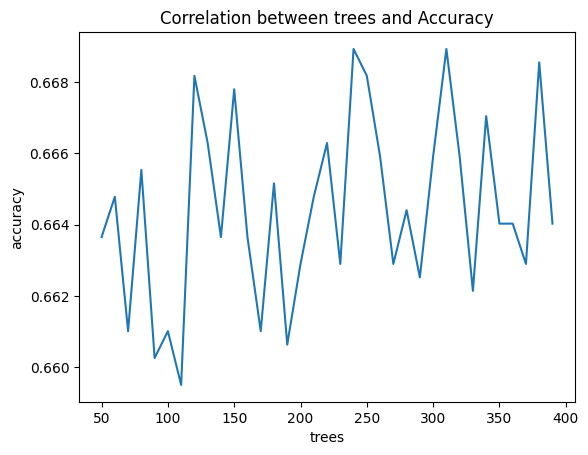

Best tree value=310


In [78]:
a=50
b=400
values=[]
treenumber=[]
for i in range (a,b,10):
    average_accuracy=0

    for k in range (5):
        RandomForest = RandomForestClassifier(n_estimators=i, n_jobs=(-1))
        RandomForest.fit(features_treino,has_cancer_treino)
        has_cancer_prediction=RandomForest.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    treenumber.append(i)

pyplot.plot(treenumber,values )
pyplot.xlabel('trees')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between trees and Accuracy')
pyplot.show() 

values=np.array(values)
index=np.where(values==np.max(values))
besttree=treenumber[index[0][0]]
print(f"Best tree value={besttree} accuracy = {np.max(values)}")

##### Finding the best criterion

We'll test two criterion:<br>
- Gini<br>
- Entropy<br>
- Log Loss

In [79]:
accuracy_gini=0
accuracy_entropy=0
accuracy_logloss=0
for i in range (5):
    RandomForestGini = RandomForestClassifier(criterion="gini", n_jobs=(-1))
    RandomForestGini.fit(features_treino,has_cancer_treino)
    has_cancer_predictionGini=RandomForest.predict(features_teste)
    accuracy_gini_iter = accuracy_score(has_cancer_teste, has_cancer_predictionGini)
    accuracy_gini+=accuracy_gini_iter

    RandomForestEntropy = RandomForestClassifier(criterion="entropy", n_jobs=(-1))
    RandomForestEntropy.fit(features_treino,has_cancer_treino)
    has_cancer_predictionEntropy=RandomForest.predict(features_teste)
    accuracy_entropy_iter = accuracy_score(has_cancer_teste, has_cancer_predictionEntropy)
    accuracy_entropy+=accuracy_entropy_iter

    RandomForestlogloss = RandomForestClassifier(criterion="log_loss", n_jobs=(-1))
    RandomForestlogloss.fit(features_treino,has_cancer_treino)
    has_cancer_predictionlogloss=RandomForest.predict(features_teste)
    accuracy_logloss_iter = accuracy_score(has_cancer_teste, has_cancer_predictionlogloss)
    accuracy_logloss+=accuracy_logloss_iter

accuracy_gini=accuracy_gini/5
accuracy_entropy=accuracy_entropy/5
accuracy_logloss=accuracy_logloss/5

bestcriterionacc=(np.max([accuracy_entropy, accuracy_gini, accuracy_logloss]))
if bestcriterionacc==accuracy_gini:
    bestcriterionname='gini'
if bestcriterionacc==accuracy_entropy:
    bestcriterionname='entropy'
if bestcriterionacc==accuracy_logloss:
    bestcriterionname='log_loss'

In [80]:
print(f"Accuracy Gini = {accuracy_gini} in a percentage of 100 = {accuracy_gini*100}")
print(f"Accuracy Entropy = {accuracy_entropy} in a percentage of 100 = {accuracy_entropy*100}")
print(f"Accuracy Log Loss = {accuracy_logloss} in a percentage of 100 = {accuracy_logloss*100}")
print(f"Best criterion = {bestcriterionname} with an accuracy of = {bestcriterionacc}")

Accuracy Gini = 0.6629001883239172 in a percentage of 100 = 66.29001883239172
Accuracy Entropy = 0.6629001883239172 in a percentage of 100 = 66.29001883239172
Accuracy Log Loss = 0.6629001883239172 in a percentage of 100 = 66.29001883239172
Best criterion = log_loss with an accuracy of = 0.6629001883239172


##### Finding the best minimum samples split

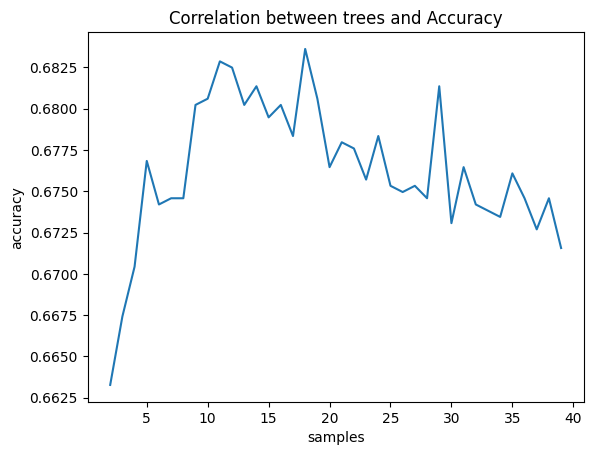

Best Sample value=18, max accuracy=0.6836158192090396


In [81]:
lower=2
upper=40
values=[]
samplesnumber=[]
for i in range (lower,upper):
    average_accuracy=0

    for k in range (5):
        RandomForest = RandomForestClassifier(min_samples_split=i, n_jobs=(-1))
        RandomForest.fit(features_treino,has_cancer_treino)
        has_cancer_prediction=RandomForest.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    samplesnumber.append(i)
    
pyplot.plot(samplesnumber,values )
pyplot.xlabel('samples')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between trees and Accuracy')
pyplot.show()


values=np.array(values)
index=np.where(values==np.max(values))
bestsample=samplesnumber[index[0][0]]
print(f"Best Sample value={bestsample}, max accuracy={np.max(values)}")


##### Finding the best Tree deepth

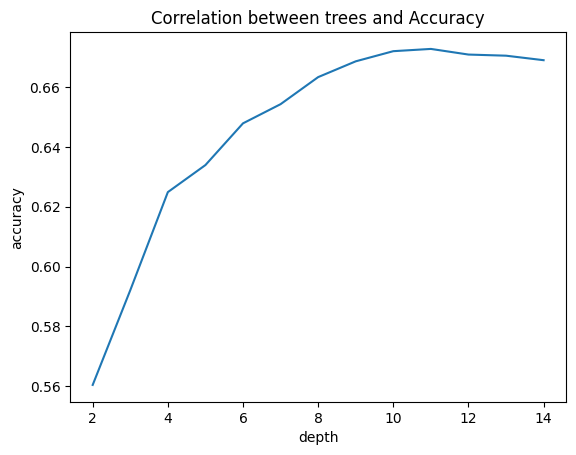

Best depth value=11, max accuracy=0.6726930320150659


In [82]:
lower=2
upper=15
values=[]
depthnumber=[]
for i in range (lower,upper):
    average_accuracy=0

    for k in range (5):
        RandomForest = RandomForestClassifier(max_depth=i, n_jobs=(-1))
        RandomForest.fit(features_treino,has_cancer_treino)
        has_cancer_prediction=RandomForest.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    depthnumber.append(i)



pyplot.plot(depthnumber,values )
pyplot.xlabel('depth')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between trees and Accuracy')
pyplot.show()

values=np.array(values)
index=np.where(values==np.max(values))
bestdepthnumber=depthnumber[index[0][0]]
print(f"Best depth value={bestdepthnumber}, max accuracy={np.max(values)}")

##### Finding the best Max Features

In this we have two options $\sqrt{TotalFeatures}$ or log<sub>2</sub>(TotalFeatures), that have been shown by studies to be the best two value.<br> But these two values tend to be very similar unless TotalFeatures is a high number. 

In [83]:
accuracy_sqr=0
accuracy_log=0
for i in range (5):
    RandomForestsqr = RandomForestClassifier(max_features='sqrt', n_jobs=(-1))
    RandomForestsqr.fit(features_treino,has_cancer_treino)
    has_cancer_predictionsqr=RandomForest.predict(features_teste)
    accuracy_sqr_iter = accuracy_score(has_cancer_teste, has_cancer_predictionsqr)
    accuracy_sqr+=accuracy_sqr_iter

    RandomForestlog = RandomForestClassifier(max_features='log2', n_jobs=(-1))
    RandomForestlog.fit(features_treino,has_cancer_treino)
    has_cancer_predictionlog=RandomForest.predict(features_teste)
    accuracy_log_iter = accuracy_score(has_cancer_teste, has_cancer_predictionlog)
    accuracy_log+=accuracy_log_iter

accuracy_sqr=accuracy_sqr/5
accuracy_log=accuracy_log/5

best_maxsamples_acc=(np.max([accuracy_sqr, accuracy_log,]))
if best_maxsamples_acc==accuracy_sqr:
    best_max_samples_name='sqrt'
if best_maxsamples_acc==accuracy_log:
    best_max_samples_name='log2'

print(f"Accuracy Sqr= {accuracy_sqr} in a percentage of 100 = {accuracy_sqr*100}")
print(f"Accuracy Log= {accuracy_log} in a percentage of 100 = {accuracy_log*100}")
print(f"Difference = {abs(accuracy_log-accuracy_sqr)}")
print(f"Best Max Samples = {best_max_samples_name} with an accuracy of = {best_maxsamples_acc}")

Accuracy Sqr= 0.6704331450094162 in a percentage of 100 = 67.04331450094162
Accuracy Log= 0.6704331450094162 in a percentage of 100 = 67.04331450094162
Difference = 0.0
Best Max Samples = log2 with an accuracy of = 0.6704331450094162


##### Model with "optimal stacking"

In [89]:
accuracy_optimal=0
for i in range(5):
    RandomForestoptimal = RandomForestClassifier(n_estimators=besttree, criterion=bestcriterionname, min_samples_split=bestsample, max_features=bestsample, max_depth=bestdepthnumber, n_jobs=(-1))
    RandomForestoptimal.fit(features_treino,has_cancer_treino)
    has_cancer_predictionoptimal=RandomForest.predict(features_teste)
    accuracy_optimal_iter = accuracy_score(has_cancer_teste, has_cancer_predictionoptimal)
    accuracy_optimal+=accuracy_optimal_iter
accuracy_optimal=accuracy_optimal/5

print (f"Optimal stacking model accuracy = {accuracy_optimal}")

Optimal stacking model accuracy = 0.6704331450094162


###### Confusion Matrix "optimal stacking"

In [ ]:
cm=confusion_matrix(has_cancer_teste, has_cancer_predictionoptimal)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

###### Tree from "optimal stacking" model

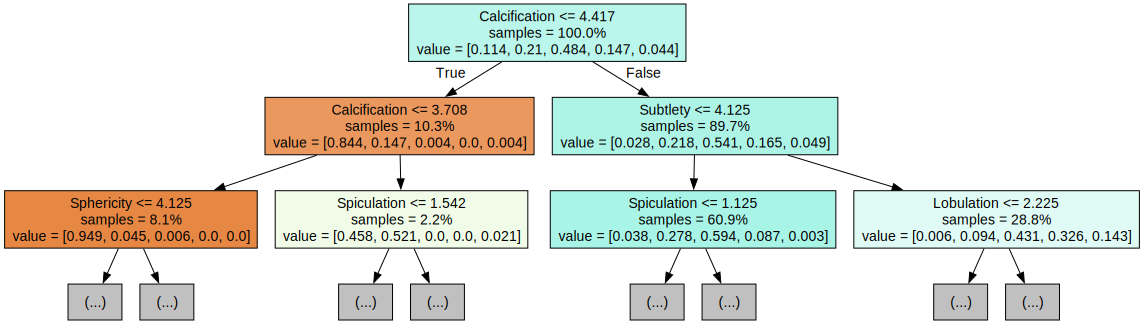

In [94]:
tree = RandomForestoptimal.estimators_[i]
dot_data = export_graphviz(tree,
                            feature_names=features_treino.columns,  
                            filled=True,  
                            max_depth=2, 
                            impurity=False, 
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

##### Proposal conclusions

Since the accuracy of the model with the stacked optimal parameters is lower than the accuracy of the tuning of some individual parameters we can safelly say that stacking the best parameters isn't a good idea and the "optimal" value for a parameter can change depending on the value of other parameters

#### The computer is Smarter Assumption